In [1]:
import scikitplot as skplt
from imblearn.over_sampling import SMOTE
from sklearn import model_selection
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve, learning_curve, cross_validate, StratifiedShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import sys
np.set_printoptions(suppress=True, threshold=sys.maxsize)
plt.style.use('ggplot')
# Using panda.io to read the dataset
unprocessed_data_X = pd.read_csv("heartdisease300.csv")
unprocessed_data_y = unprocessed_data_X.loc[:, "target"]

In [2]:
# Feature Selection using a chi-squared scoring function
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html
feature_selection = SelectKBest(chi2, k=13)
feature_selection_data = feature_selection.fit_transform(
    unprocessed_data_X, unprocessed_data_y)
processed_data_X = feature_selection_data[:, :-1]
processed_data_Y = feature_selection_data[:, 12]
# Hyperparameters: score_func - chi2
# This feature had the lowest chi2 scores and will be excluded:
# fasting blood sugar > 120 mg/dl

In [3]:
# SMOTE
# https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html
smote_processed_data_X, smote_processed_data_Y = SMOTE(
).fit_resample(processed_data_X, processed_data_Y)
# Hyperparameters: sampling_strategy - auto = resampling only the minority class
# k_neighbors - default = 5
# ??? new entries were created by SMOTE to oversample the minority

In [4]:
# 70%/30% Training Test Split
processed_train_X, processed_test_X, processed_train_Y, processed_test_Y = train_test_split(
    processed_data_X, processed_data_Y, test_size=0.3, random_state=1)
smote_train_X, smote_test_X, smote_train_Y, smote_test_Y = train_test_split(
    smote_processed_data_X, smote_processed_data_Y, test_size=0.3, random_state=1)
# Hyperparameters: test_size - 30
# train_size - 70
# shuffle default = True

<AxesSubplot:xlabel='3', ylabel='4'>

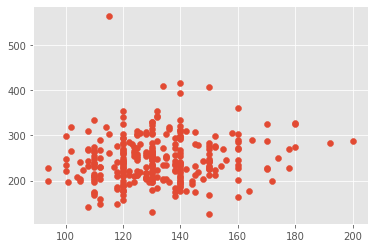

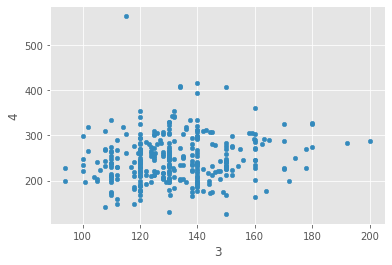

In [5]:
# Scatterplot for unprocessed data
# print(unprocessed_data_X)
g1 = unprocessed_data_X.loc[:, "age":"target"]
plt.scatter('trestbps', 'chol', data=g1)

# Scatterplot for SMOTE treated data
# Convert SMOTE-treated data numpy array to DataFrame to use .loc
smoteDF = pd.DataFrame(smote_processed_data_X)
smoteDF.to_csv("SMOTEData.csv")

# print(smoteDF)
g2 = smoteDF.loc[1025:1051, :]  # New data from SMOTE
# print (g2)
smoteDF.plot(x=3, y=4, kind='scatter')

In [6]:
# RF
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

random_forest = RandomForestClassifier()

# RF w/ SMOTE
random_forest_smote = random_forest.fit(smote_train_X, smote_train_Y)
random_forest_smote_cv = cross_validate(
    random_forest_smote, smote_train_X, smote_train_Y)
print('---RANDOM FOREST---')
print('Random Forest w/ SMOTE Training Set Accuracy: ', end="")
print(np.mean(random_forest_smote_cv['test_score']))
print('Random Forest w/ SMOTE Test Set Accuracy: ', end="")
print(random_forest_smote.score(smote_test_X, smote_test_Y))

# RF w/o SMOTE
random_forest_processed = random_forest.fit(
    processed_train_X, processed_train_Y)
random_forest_processed_cv = cross_validate(
    random_forest_processed, processed_train_X, processed_train_Y)
print('Random Forest w/o SMOTE Training Accuracy: ', end="")
print(np.mean(random_forest_processed_cv['test_score']))
print('Random Forest w/o SMOTE Test Set Accuracy: ', end="")
print(random_forest_processed.score(processed_test_X, processed_test_Y))

rf_predicted_nosmote = random_forest_processed.predict(processed_test_X)
rf_predicted_smote = random_forest_smote.predict(smote_test_X)

# confusion matrix
print("confusion matrix")
print("\n")
print("without smote")
print("\n")
rf_conf_matrix_nosmote = confusion_matrix(
    processed_test_Y, rf_predicted_nosmote)
print(rf_conf_matrix_nosmote)
print("\n")
print("with smote")
print("\n")
r_conf_matrix_smote = confusion_matrix(smote_test_Y, rf_predicted_smote)
print(r_conf_matrix_smote)

# scores for stat
print("\n")
print("without smote")
print(classification_report(processed_test_Y, rf_predicted_nosmote))
print("with smote")
print(classification_report(smote_test_Y, rf_predicted_smote))

---RANDOM FOREST---
Random Forest w/ SMOTE Training Set Accuracy: 0.8385507246376811
Random Forest w/ SMOTE Test Set Accuracy: 0.8080808080808081
Random Forest w/o SMOTE Training Accuracy: 0.7970099667774087
Random Forest w/o SMOTE Test Set Accuracy: 0.8351648351648352
confusion matrix


without smote


[[43  6]
 [ 9 33]]


with smote


[[47  6]
 [ 4 42]]


without smote
              precision    recall  f1-score   support

         0.0       0.83      0.88      0.85        49
         1.0       0.85      0.79      0.81        42

    accuracy                           0.84        91
   macro avg       0.84      0.83      0.83        91
weighted avg       0.84      0.84      0.83        91

with smote
              precision    recall  f1-score   support

         0.0       0.92      0.89      0.90        53
         1.0       0.88      0.91      0.89        46

    accuracy                           0.90        99
   macro avg       0.90      0.90      0.90        99
weighted avg    

In [7]:
#Grid Search
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(unprocessed_data_X, unprocessed_data_y)

print(
    "The best parameters are %s with a score of %0.2f"
    % (grid.best_params_, grid.best_score_)
)


The best parameters are {'C': 10000.0, 'gamma': 1e-05} with a score of 1.00


In [8]:
#SVM

svm = SVC(kernel='rbf', gamma=0.00001,C=10000, probability=True)

# SVM w/ SMOTE
svm_smote=svm.fit(smote_train_X, smote_train_Y)
svm_predicted_smote = svm_smote.predict(smote_test_X)
print('---SUPPORT VECTOR MACHINE---')
print('SVM w/ SMOTE Test Set Accuracy: ', end="")
print(svm_smote.score(smote_test_X, smote_test_Y))
print('SVM w/ SMOTE Training Set Accuracy: ', end="")
print(svm_smote.score(smote_train_X, smote_train_Y))

# SVM w/o SMOTE
svm_nosmote = svm.fit(processed_data_X, processed_data_Y)
svm_predicted_nosmote = svm_nosmote.predict(processed_test_X)

print('SVM w/o SMOTE Test Set Accuracy: ', end="")
print(svm_nosmote.score(processed_test_X, processed_test_Y))
print('SVM w/o SMOTE Training Set Accuracy: ', end="")
print(svm_nosmote.score(processed_train_X, processed_train_Y))
print()

#confusion matrix
print("confusion matrix")
print("\n")
print("without smote")
print("\n")
svc_conf_matrix_nosmote = confusion_matrix(processed_test_Y,svm_predicted_nosmote)
print(svc_conf_matrix_nosmote)
print("\n")
print("with smote")
print("\n")
svc_conf_matrix_smote = confusion_matrix(smote_test_Y,svm_predicted_smote)
print(svc_conf_matrix_smote)

#scores for stat
print("\n")
print("without smote")
print(classification_report(processed_test_Y,svm_predicted_nosmote))
print("with smote")
print(classification_report(smote_test_Y,svm_predicted_smote))



---SUPPORT VECTOR MACHINE---
SVM w/ SMOTE Test Set Accuracy: 0.7878787878787878
SVM w/ SMOTE Training Set Accuracy: 0.868995633187773
SVM w/o SMOTE Test Set Accuracy: 0.8791208791208791
SVM w/o SMOTE Training Set Accuracy: 0.8490566037735849

confusion matrix


without smote


[[45  4]
 [ 7 35]]


with smote


[[38 15]
 [ 6 40]]


without smote
              precision    recall  f1-score   support

         0.0       0.87      0.92      0.89        49
         1.0       0.90      0.83      0.86        42

    accuracy                           0.88        91
   macro avg       0.88      0.88      0.88        91
weighted avg       0.88      0.88      0.88        91

with smote
              precision    recall  f1-score   support

         0.0       0.86      0.72      0.78        53
         1.0       0.73      0.87      0.79        46

    accuracy                           0.79        99
   macro avg       0.80      0.79      0.79        99
weighted avg       0.80      0.79      0.79

Best parameters for Ensembling + SMOTE: {'voting': 'hard', 'weights': (1, 1)}
Score: 0.7913043478260869


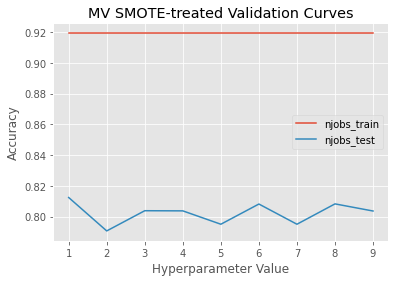

              precision    recall  f1-score   support

         0.0       0.90      1.00      0.95        53
         1.0       1.00      0.87      0.93        46

    accuracy                           0.94        99
   macro avg       0.95      0.93      0.94        99
weighted avg       0.95      0.94      0.94        99

Validation accuracy for Ensembling w/ SMOTE: 0.7584210526315789

Best parameters for Ensembling w/o SMOTE: {'voting': 'soft', 'weights': (1, 1)}
Score: 0.813953488372093


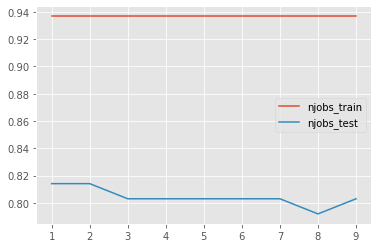

              precision    recall  f1-score   support

         0.0       0.89      1.00      0.94        49
         1.0       1.00      0.86      0.92        42

    accuracy                           0.93        91
   macro avg       0.95      0.93      0.93        91
weighted avg       0.94      0.93      0.93        91

Validation accuracy for Ensembling w/o SMOTE: 0.8140350877192983
confusion matrix


without smote


[[49  0]
 [ 6 36]]


with smote


[[53  0]
 [ 6 40]]


without smote
              precision    recall  f1-score   support

         0.0       0.89      1.00      0.94        49
         1.0       1.00      0.86      0.92        42

    accuracy                           0.93        91
   macro avg       0.95      0.93      0.93        91
weighted avg       0.94      0.93      0.93        91

with smote
              precision    recall  f1-score   support

         0.0       0.90      1.00      0.95        53
         1.0       1.00      0.87      0.93        46

  

In [9]:
#TODO: MV

# estimators for ensembling MV
estimators = [('RandomForest', random_forest), ('SVM', svm)]
ensemble_smote = VotingClassifier(estimators=estimators, voting='hard', weights=[
                                  1, 1])  # hard voting, because we are doing MV
ensemble_smote.fit(smote_test_X, smote_test_Y)



# # TODO: Adjust MV Hyperparameters
# Exhaustive Grid Search with Cross Validation for Optimal Hyperparameters

params = {'voting': ['soft', 'hard'],
          'weights': [(1, 1)]}

cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid_smote = GridSearchCV(ensemble_smote, param_grid=params, cv=cv)

grid_smote.fit(smote_train_X, smote_train_Y)
print("Best parameters for Ensembling + SMOTE: ", end="")
print(grid_smote.best_params_)
print("Score: ", end="")
print(grid_smote.best_score_)

#{'voting': 'hard', 'weights': (1, 1)}

# validation graph
param_range = np.arange(0, 10, 1, dtype=int)

train_scores, test_scores = validation_curve(
    ensemble_smote,
    smote_train_X,
    smote_train_Y,
    param_name="n_jobs",
    param_range=param_range,
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(param_range, train_scores_mean,
         label="njobs_train")
plt.plot(param_range, test_scores_mean, label="njobs_test")
plt.title("MV SMOTE-treated Validation Curves")
plt.xlabel("Hyperparameter Value")
plt.ylabel("Accuracy")

plt.legend()
plt.show()
y_pred = ensemble_smote.predict(smote_test_X)
print(classification_report(smote_test_Y, y_pred))

results_smote = model_selection.cross_val_score(
    ensemble_smote, smote_test_X, smote_test_Y, scoring='accuracy')

print("Validation accuracy for Ensembling w/ SMOTE: ", end="")
print(results_smote.mean())
print()

ensemble_proc = VotingClassifier(estimators, voting='hard', weights=[
                                 1, 1])  # hard voting, because we are doing MV
ensemble_proc.fit(processed_test_X, processed_test_Y)

# # TODO: Adjust MV Hyperparameters
# Exhaustive Grid Search with Cross Validation for Optimal Hyperparameters
params = {'voting': ['soft', 'hard'],
          'weights': [(1, 1)]}

cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid_proc = GridSearchCV(ensemble_proc, param_grid=params, cv=cv)

grid_proc.fit(processed_train_X, processed_train_Y)
print("Best parameters for Ensembling w/o SMOTE: ", end="")
print(grid_proc.best_params_)
print("Score: ", end="")
print(grid_proc.best_score_)

#{'voting': 'hard', 'weights': (1, 1)}

param_range = np.arange(1, 10, 1, dtype=int)
train_scores, test_scores = validation_curve(
    ensemble_proc,
    processed_test_X,
    processed_test_Y,
    param_name="n_jobs",
    param_range=param_range,
)
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(param_range, train_scores_mean, label="njobs_train")
plt.plot(param_range, test_scores_mean, label="njobs_test")

plt.legend()
plt.show()
y_pred = ensemble_proc.predict(processed_test_X)
print(classification_report(processed_test_Y, y_pred))

results_proc = model_selection.cross_val_score(
    ensemble_proc, processed_test_X, processed_test_Y, scoring='accuracy')

print("Validation accuracy for Ensembling w/o SMOTE: ", end="")
print(results_proc.mean())

# skplt.metrics.plot_confusion_matrix(processed_test_Y, y_pred, figsize=(10, 8))
# plt.show()
# confusion matrix
print()
print("confusion matrix")
print("\n")
print("without smote")
print("\n")
y_proc_pred = ensemble_proc.predict(processed_test_X)
ensemble_matrix_proc = confusion_matrix(processed_test_Y, y_proc_pred)
print(ensemble_matrix_proc)
print("\n")
print("with smote")
print("\n")
y_smote_pred = ensemble_smote.predict(smote_test_X)
ensemble_matrix_smote = confusion_matrix(smote_test_Y, y_smote_pred)
print(ensemble_matrix_smote)

# scores for stat
print("\n")
print("without smote")
print(classification_report(processed_test_Y, y_proc_pred))
print("with smote")
print(classification_report(smote_test_Y, y_smote_pred))

# # https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
# # https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
# # Refer to MV documentation for possible parameter values
